The True Strength Index (TSI) is a momentum oscillator that is primarily used by traders to determine whether a market is an upward or a downward momentum and trade along with it.

Technical Indicators: In finance and trading, technical indicators are mathematical calculations based on historical price, volume, or open interest data. Traders and analysts use these indicators to help forecast future price movements and make trading decisions.

Relative Strength Index (RSI): RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is used to identify overbought or oversold conditions in a market.

Stochastic Oscillator: The Stochastic Oscillator is another momentum indicator that compares a security's closing price to its price range over a specified period. It helps identify potential trend reversals or overbought/oversold conditions.

Moving Average Convergence Divergence (MACD): MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It consists of a MACD line (the difference between two exponential moving averages) and a signal line (a moving average of the MACD line).

True Strength Index (TSI): The True Strength Index is a technical momentum oscillator used to identify trend direction, overbought/oversold conditions, and potential entry/exit points. It's calculated using double smoothed price changes and exponential moving averages of these changes. TSI is designed to filter out short-term price fluctuations and focus on the underlying trend.



In [128]:
from datetime import date, datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import pytz
from polygon.rest import RESTClient
from polygon.rest.models import (
    Agg,
    DailyOpenCloseAgg,
    GroupedDailyAgg,
    PreviousCloseAgg,
    Sort,
)
from polygon.rest.models.request import RequestOptionBuilder
from urllib3 import HTTPResponse


def get_client():
    return RESTClient("ocunxnOqC0pnltRqT3VkOiKeCmPE49L7")


# TODO: Account for market holidays and half-days
# TODO: Determine timezone from stock/equity ticker
def within_trading_hours(
    timestamp: Union[str, int, datetime, date], timezone: str
) -> bool:
    """
    Determine whether a given instant is within trading hours for a particular exchange.

    :param timestamp: The timestamp (in milliseconds) to be checked.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: True if the timestamp is within trading hours, False otherwise.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    if dt.weekday() < 5:
        opening_time = dt.replace(hour=9, minute=30, second=0, microsecond=0)
        closing_time = dt.replace(hour=16, minute=0, second=0, microsecond=0)
        return opening_time <= dt <= closing_time
    else:
        return False


# TODO: Determine timezone from stock/equity ticker
def parse_timestamp(timestamp: Union[str, int, datetime, date], timezone: str) -> str:
    """
    Parse a timestamp to a readable format for easy comparisons.

    :param timestamp: The timestamp (in milliseconds) to be formatted.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: Date-time representation in the following format: %Y-%m-%d %H:%M:%S %Z.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    return dt.strftime("%Y-%m-%d %H:%M:%S %Z")


def agg_to_dict(agg: Agg) -> dict[str, Union[None, float, int, bool]]:
    """
    Convert an aggregate object to a dictionary, and add any extra data that may be useful.

    :param agg: The aggregate object to parse.
    :return: Dictionary with keys corresponding to attributes of the object.
    """
    return {
        "open": agg.open,
        "high": agg.high,
        "low": agg.low,
        "close": agg.close,
        "volume": agg.volume,
        "vwap": agg.vwap,
        "timestamp": agg.timestamp,
        "datetime": parse_timestamp(agg.timestamp, "America/New_York"),
        "transactions": agg.transactions,
        "otc": agg.otc,
    }


def list_aggs(
    client: RESTClient,
    ticker: str,
    multiplier: int,
    timespan: str,
    # "from" is a keyword in python https://www.w3schools.com/python/python_ref_keywords.asp
    from_: Union[str, int, datetime, date],
    to: Union[str, int, datetime, date],
    include_extended_hours: bool = True,
    adjusted: Optional[bool] = None,
    sort: Optional[Union[str, Sort]] = None,
    limit: Optional[int] = None,
    params: Optional[Dict[str, Any]] = None,
    raw: bool = False,
    options: Optional[RequestOptionBuilder] = None,
) -> pd.DataFrame:
    """
    List aggregate bars for a ticker over a given date range in custom time window sizes.

    :param client: The RESTClient object to perform the request with.
    :param ticker: The ticker symbol.
    :param multiplier: The size of the timespan multiplier.
    :param timespan: The size of the time window.
    :param from_: The start of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param to: The end of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param include_extended_hours: True if pre-market and after-hours trading data are to be included, False otherwise.
    :param adjusted: Whether or not the results are adjusted for splits. By default, results are adjusted. Set this to false to get results that are NOT adjusted for splits.
    :param sort: Sort the results by timestamp. asc will return results in ascending order (oldest at the top), desc will return results in descending order (newest at the top).The end of the aggregate time window.
    :param limit: Limits the number of base aggregates queried to create the aggregate results. Max 50000 and Default 5000. Read more about how limit is used to calculate aggregate results in Polygon's on Aggregate Data API Improvements.
    :param params: Any additional query params.
    :param raw: Return raw object instead of results object.
    :return: Pandas DataFrame representation of aggregate objects.
    """
    aggs = []
    for a in client.list_aggs(
        ticker,
        multiplier,
        timespan,
        from_,
        to,
        adjusted=adjusted,
        sort=sort,
        limit=limit,
        params=params,
        raw=raw,
        options=options,
    ):
        if include_extended_hours or within_trading_hours(
            a.timestamp, "America/New_York"
        ):
            aggs.append(agg_to_dict(a))
    return pd.DataFrame(aggs)

# Set the display option to show all columns
pd.set_option('display.width', None)  # Allow display of wide DataFrames

data = list_aggs(
        get_client(), "SPY", 1, "day", "2000-01-01", "2018-12-31", limit=50000
    )

data

,open,high,low,close,volume,vwap,timestamp,datetime,transactions,otc
0,102.530,102.8000,101.55,101.96,45417600.0,102.2064,1063166400000,2003-09-10 00:00:00 EDT,25951,None
1,102.100,102.7600,101.84,102.26,38038300.0,102.3182,1063252800000,2003-09-11 00:00:00 EDT,22580,None
2,101.910,102.6400,101.35,102.45,41159600.0,101.9165,1063339200000,2003-09-12 00:00:00 EDT,26091,None
3,102.520,102.6300,101.95,102.09,20710600.0,102.2676,1063598400000,2003-09-15 00:00:00 EDT,15670,None
4,102.232,103.6400,102.17,103.58,37103300.0,103.0466,1063684800000,2003-09-16 00:00:00 EDT,19074,None
...,...,...,...,...,...,...,...,...,...,...
3849,239.040,240.8355,234.27,234.34,147311588.0,237.2807,1545627600000,2018-12-24 00:00:00 EST,683157,None
3850,235.970,246.1800,233.76,246.18,218930378.0,239.5597,1545800400000,2018-12-26 00:00:00 EST,1032190,None
3851,242.570,248.2900,238.96,248.07,186492032.0,243.4997,1545886800000,2018-12-27 00:00:00 EST,978525,None
3852,249.580,251.4000,246.45,247.75,153456587.0,248.5814,1545973200000,2018-12-28 00:00:00 EST,800102,None


In [129]:
# As
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame()
df["close"] = data["close"]
df["datetime"] = data["datetime"]
# Calculate the Simple Moving Average (SMA)
df["SMA"] = df["close"].rolling(window=200).mean()
#suming df is your DataFrame with columns 'close', 'datetime', and 'SMA'
df.set_index('datetime', inplace=True)

print(df)


                          close        SMA
datetime                                  
2003-09-10 00:00:00 EDT  101.96        NaN
2003-09-11 00:00:00 EDT  102.26        NaN
2003-09-12 00:00:00 EDT  102.45        NaN
2003-09-15 00:00:00 EDT  102.09        NaN
2003-09-16 00:00:00 EDT  103.58        NaN
...                         ...        ...
2018-12-24 00:00:00 EST  234.34  274.90415
2018-12-26 00:00:00 EST  246.18  274.74245
2018-12-27 00:00:00 EST  248.07  274.59920
2018-12-28 00:00:00 EST  247.75  274.46145
2018-12-31 00:00:00 EST  249.92  274.33605

[3854 rows x 2 columns]


# True Strength Index (TSI)

## TSI Line: 
##### The first component is the TSI line itself which is calculated by first determining the actual price change (current closing price minus the previous closing price) and the absolute price change (absolute values of the actual price change). Then an EMA with 25 as the number of periods (long) is taken for both the actual price change and the absolute price change. These two EMAs are then again smoothed by a 13-day period (short) Exponential Moving Average. This process of smoothing a data series with two EMAs is known as double smoothing and the goal of doing this is to eliminate noise from the data. Now, the double-smoothed actual price change is divided by the double-smoothed absolute price change and then multiplied by 100 to obtain the readings of the TSI line. Note that the parameters (25, 13) we took into consideration are the typical setting but can be tuned accordingly. The calculation might be fuzzy but can be easily understood if we interpret it in the form of a formula or representation:

## Signal line: 
##### The next component is the Signal line component which is nothing but an Exponential Moving Average of the TSI for a specified number of periods (falls within 7 to 12 periods). Most traders prefer periods near to 7 for day trading purposes and close to 12 for long-term investing. In this article, we are going with 12 as the number of periods since we will be dealing with a daily timeframe stock data rather than a minute timeframe. The calculation can be represented as follows:


In [130]:

def get_tsi(close, long, short, signal):
    diff = close - close.shift(1)
    abs_diff = abs(diff)
    
    diff_smoothed = diff.ewm(span = long, adjust = False).mean()
    diff_double_smoothed = diff_smoothed.ewm(span = short, adjust = False).mean()
    abs_diff_smoothed = abs_diff.ewm(span = long, adjust = False).mean()
    abs_diff_double_smoothed = abs_diff_smoothed.ewm(span = short, adjust = False).mean()
    
    tsi = (diff_double_smoothed / abs_diff_double_smoothed) * 100
    signal = tsi.ewm(span = signal, adjust = False).mean()
    tsi = tsi[tsi.index >= '2000-01-01'].dropna()
    signal = signal[signal.index >= '2000-01-01'].dropna()
    
    return tsi, signal

df['tsi'], df['signal_line'] = get_tsi(df['close'], 25, 13, 12)
df = df[df.index >= '2000-01-01']
df


,close,SMA,tsi,signal_line
datetime,,,,
2003-09-10 00:00:00 EDT,101.96,NaN,NaN,NaN
2003-09-11 00:00:00 EDT,102.26,NaN,100.000000,100.000000
2003-09-12 00:00:00 EDT,102.45,NaN,100.000000,100.000000
2003-09-15 00:00:00 EDT,102.09,NaN,97.349450,99.592223
2003-09-16 00:00:00 EDT,103.58,NaN,95.476451,98.959027
...,...,...,...,...
2018-12-24 00:00:00 EST,234.34,274.90415,-37.752071,-21.745250
2018-12-26 00:00:00 EST,246.18,274.74245,-35.782438,-23.904817
2018-12-27 00:00:00 EST,248.07,274.59920,-33.470329,-25.376434


Add RSI

In [131]:
def get_rsi(df):
    change = df["close"].diff()
    change.dropna(inplace=True)

    # Create two copies of the Closing price Series
    change_up = change.copy()
    change_down = change.copy()

    # 
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0

    # Verify that we did not make any mistakes
    change.equals(change_up+change_down)

    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(14).mean()
    avg_down = change_down.rolling(14).mean().abs()

    rsi = 100 * avg_up / (avg_up + avg_down)

    return rsi

# rsi.head(20)
rsi = get_rsi(df)
df['rsi'] = get_rsi(df)

# Strategy Design
Speaking about trading strategies, to my knowledge, we could apply three types of strategies based on the True Strength Index. 

#### 1.The first one is the overbought and oversold levels. This one is the most common strategy among the momentum oscillators which reveals a buy signal whenever the components of the TSI go below the oversold level and a sell signal is generated whenever the readings of both the components rise above the overbought level. I personally don’t use this strategy since I believe the True Strength Index doesn't have a good history with the concept of overbought and oversold levels.

#### 2.The second trading strategy is the zero-line crossover which reveals a buy signal whenever the TSI’s components cross from below to above zero, likewise, a sell signal is revealed whenever the components of the TSI go from above the below zero. This strategy is effective but not as much as the next trading strategy we are going to discuss.

#### 3.The final trading strategy and the one we are going to implement in this article is the signal line crossover which reveals a buy signal whenever the TSI line crosses from below to above the Signal line, and similarly, a sell signal is revealed whenever the TSI line goes from above to below the Signal line. This strategy is one of the most-used trading strategies among the others while using the True Strength Index due to its efficiency in the market. This trading strategy can be represented as follows:

 Overbought/Oversold Conditions:

RSI is particularly useful for identifying overbought or oversold conditions. If TSI indicates a strong trend, and RSI shows overbought conditions, it might be a signal to be cautious and consider potential pullbacks.

In [132]:
import numpy as np
import pandas as pd
# TRUE STRENGTH INDEX STRATEGY

def implement_rsi_tsi_strategy(prices, tsi, signal_line, rsi):
    buy_price = []
    sell_price = []
    tsi_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if (tsi[i-1] < signal_line[i-1] and tsi[i] > signal_line[i]) or (rsi[i] < 30):
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                tsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                tsi_signal.append(0)
        elif (tsi[i-1] > signal_line[i-1] and tsi[i] < signal_line[i]) or (rsi[i] > 70):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                tsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                tsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            tsi_signal.append(0)
            
    return buy_price, sell_price, tsi_signal

buy_price, sell_price, tsi_signal = implement_rsi_tsi_strategy(df['close'], df['tsi'], df['signal_line'], df['rsi'])

/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/2547745759.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (tsi[i-1] < signal_line[i-1] and tsi[i] > signal_line[i]) or (rsi[i] < 30):
/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/2547745759.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (tsi[i-1] > signal_line[i-1] and tsi[i] < signal_line[i]) or (rsi[i] > 70):
/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/2547745759.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

/Users/ch/Library/Python/3.12/lib/python/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Users/ch/Library/Python/3.12/lib/python/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


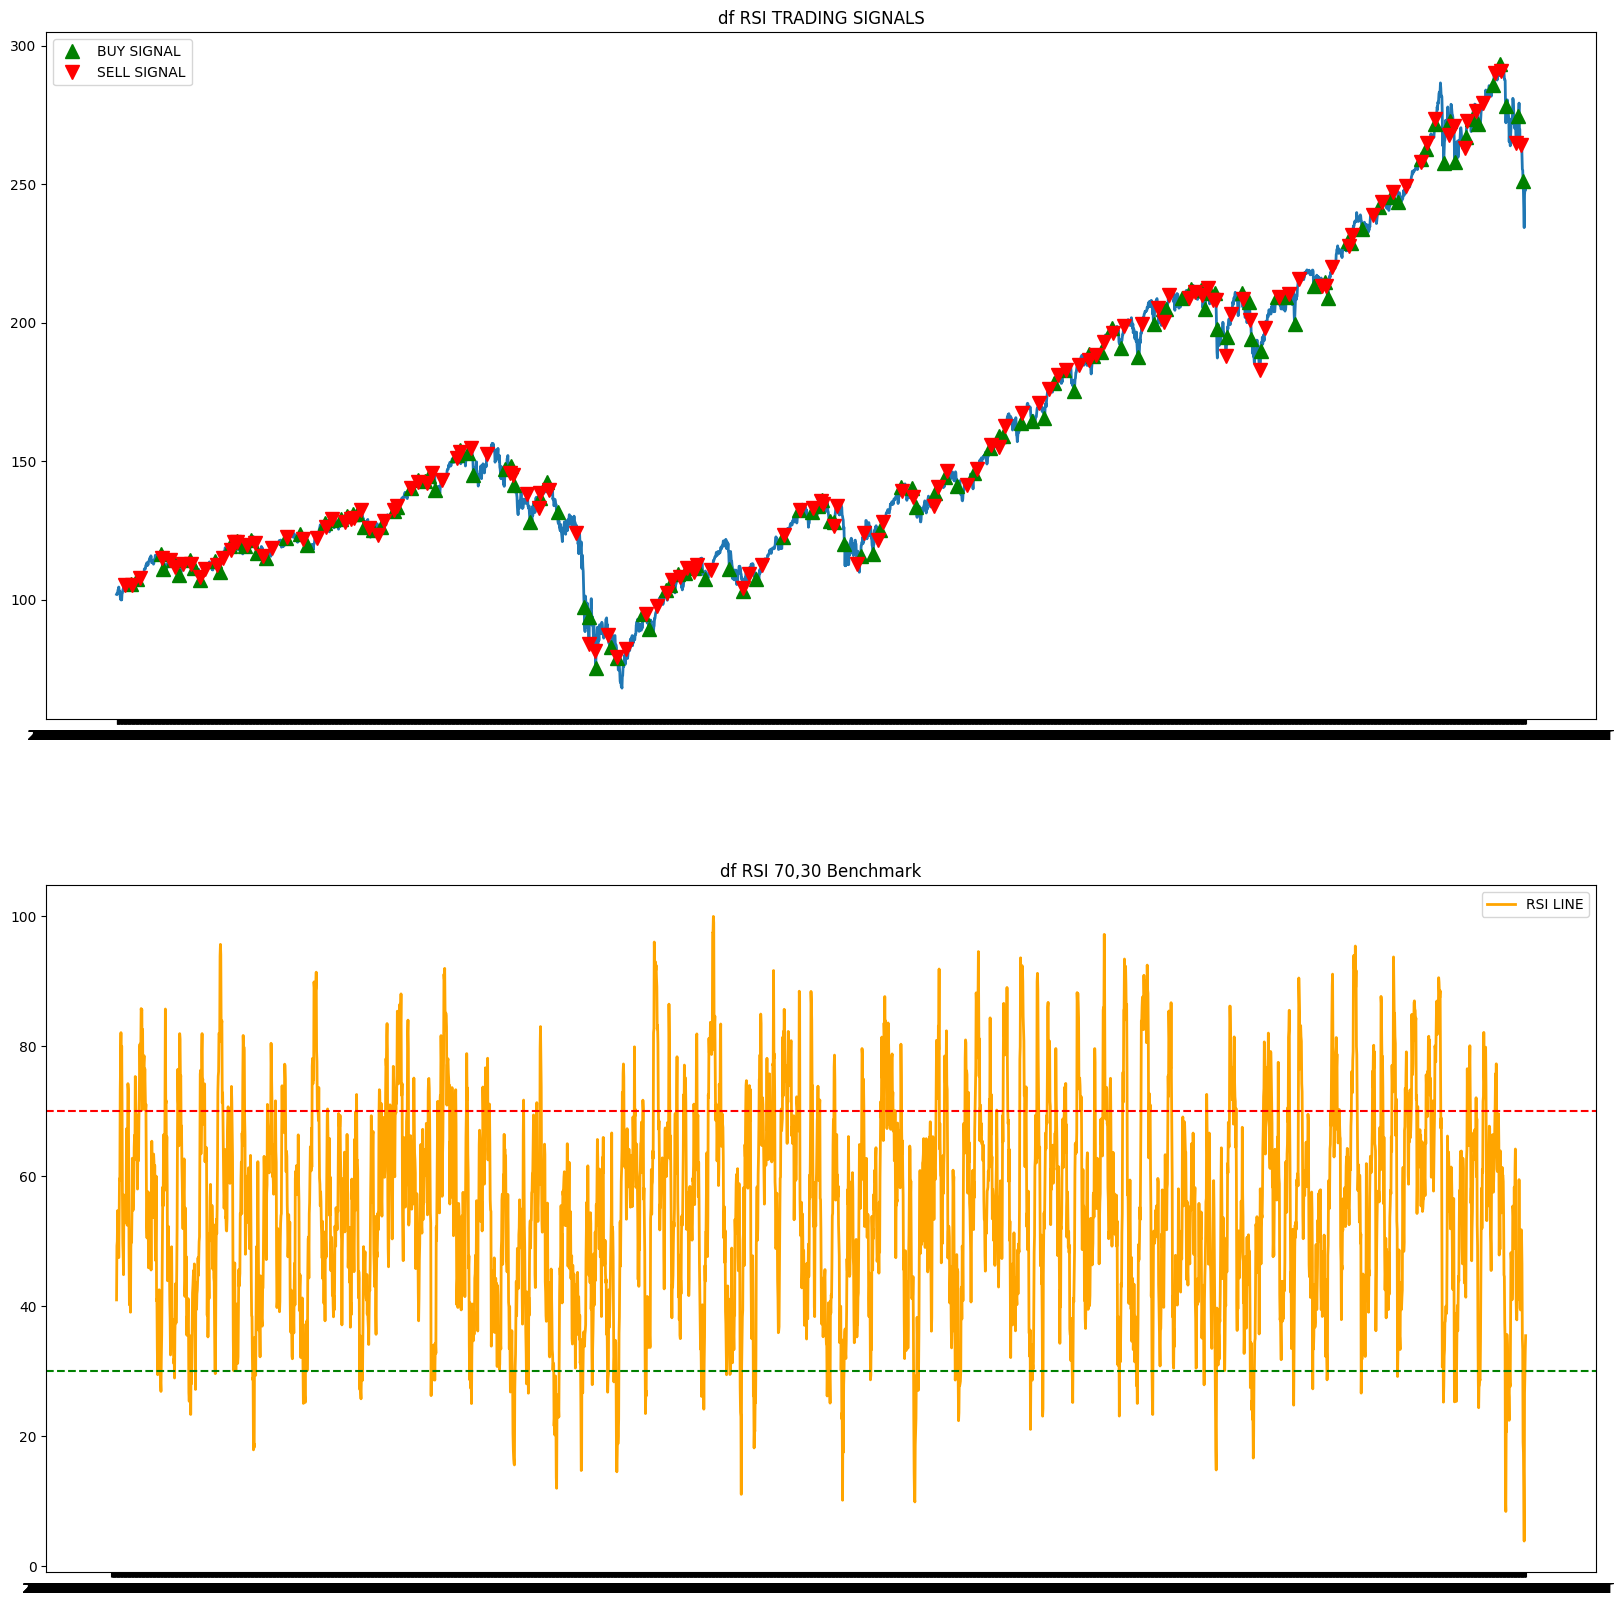

In [134]:
# TRUE STRENGTH INDEX TRADING SIGNALS PLOT
plt.figure(figsize=(20, 20))  # Set the figure size to be larger

ax1 = plt.subplot2grid((11,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan=5, colspan=1)

ax1.plot(df['close'], linewidth = 2)
ax1.plot(df.index, buy_price, marker = '^', markersize = 10, color = 'green', linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(df.index, sell_price, marker = 'v', markersize = 10, color = 'r', linewidth = 0, label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('df RSI TRADING SIGNALS')
ax2.plot(df['rsi'], linewidth = 2, color = 'orange', label = 'RSI LINE')
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')

ax2.set_title('df RSI 70,30 Benchmark')
ax2.legend()
plt.show()

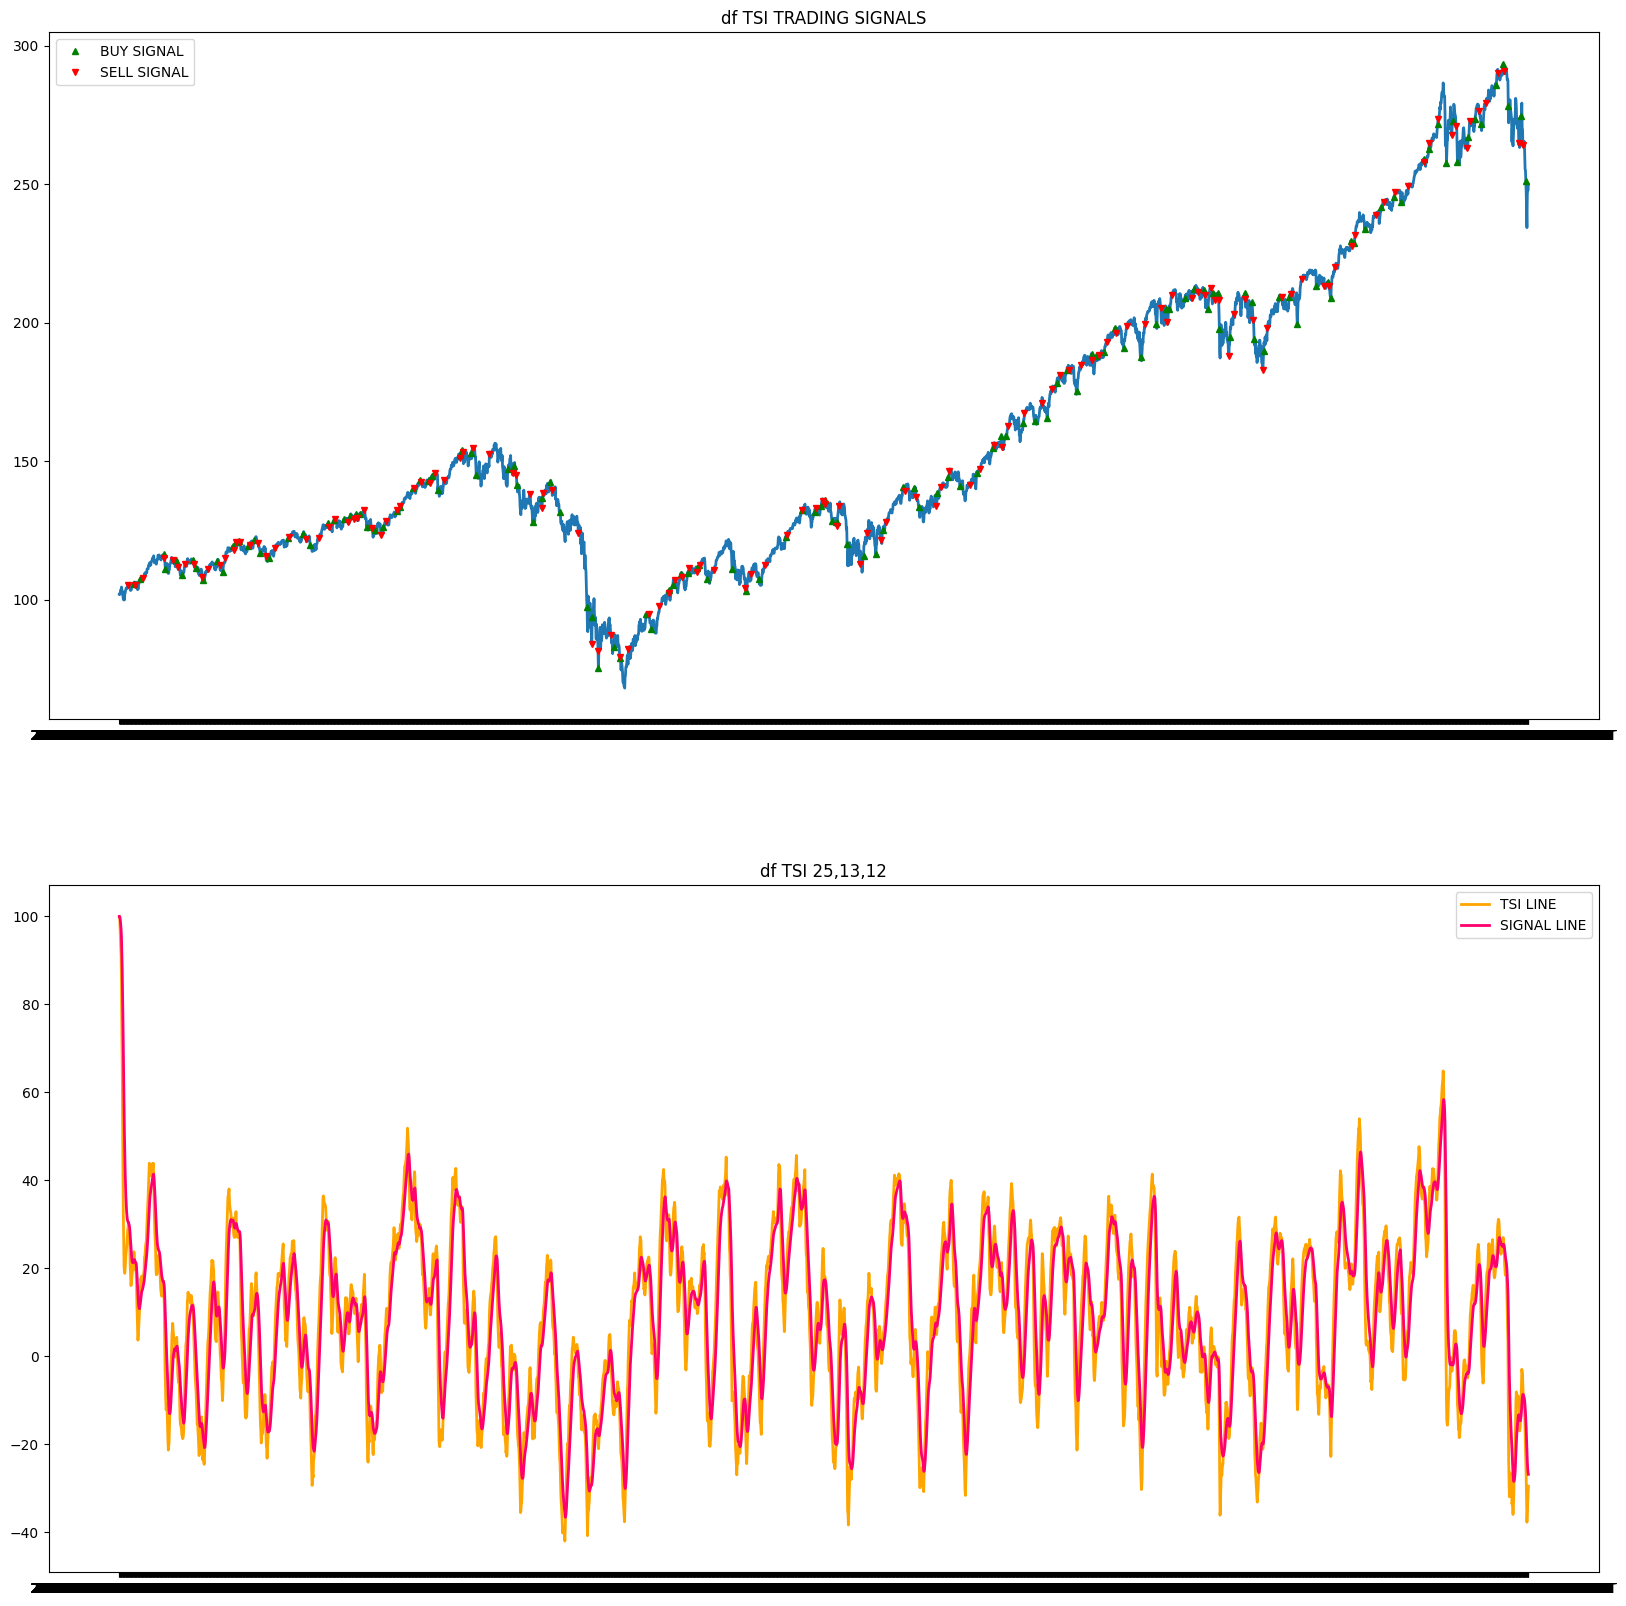

In [135]:
# TRUE STRENGTH INDEX TRADING SIGNALS PLOT
plt.figure(figsize=(20, 20))  # Set the figure size to be larger

ax1 = plt.subplot2grid((11,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan=5, colspan=1)

ax1.plot(df['close'], linewidth = 2)
ax1.plot(df.index, buy_price, marker = '^', markersize = 5, color = 'green', linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(df.index, sell_price, marker = 'v', markersize = 5, color = 'r', linewidth = 0, label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('df TSI TRADING SIGNALS')
ax2.plot(df['tsi'], linewidth = 2, color = 'orange', label = 'TSI LINE')
ax2.plot(df['signal_line'], linewidth = 2, color = '#FF006E', label = 'SIGNAL LINE')
ax2.set_title('df TSI 25,13,12')
ax2.legend()
plt.show()

In [136]:
# STOCK POSITION for TSI or RSI
def get_strategy(signal, index):
    position = []
    for i in range(len(signal)):
        if signal[i] > 1:
            position.append(1)
        else:
            position.append(0)
            
    for i in range(len(df['close'])):
        if signal[i] == 1:
            position[i] = 1
        elif signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    close_price = df['close']
    rsi = df['rsi']
    tsi = df['tsi']
    
    signal = pd.DataFrame(signal).rename(columns = {0:f'{index}_signal'}).set_index(df.index)
    position = pd.DataFrame(position).rename(columns = {0:f'{index}_position'}).set_index(df.index)

    if index == 'tsi':
        signal_line = df['signal_line']
        frames = [close_price, tsi, signal_line, signal, position]
    else:    
        frames = [close_price, rsi, signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)

    return strategy

strategy = get_strategy(tsi_signal, 'tsi')

In [137]:
# BACKTESTING
import pandas as pd 
import requests 
import matplotlib.pyplot as plt 
import numpy as np 
from math import floor 
from termcolor import colored as cl 


amzn_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
tsi_strategy_ret = []

for i in range(len(amzn_ret)):
    returns = amzn_ret['returns'][i]*strategy['tsi_position'][i]
    tsi_strategy_ret.append(returns)
    
tsi_strategy_ret_df = pd.DataFrame(tsi_strategy_ret).rename(columns = {0:'tsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['close'][0])
tsi_investment_ret = []

for i in range(len(tsi_strategy_ret_df['tsi_returns'])):
    returns = number_of_stocks*tsi_strategy_ret_df['tsi_returns'][i]
    tsi_investment_ret.append(returns)

tsi_investment_ret_df = pd.DataFrame(tsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(tsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the tsi strategy by investing $100k in df : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the tsi strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the tsi strategy by investing $100k in df : 118270.12
Profit percentage of the tsi strategy : 118%


/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/612320191.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = amzn_ret['returns'][i]*strategy['tsi_position'][i]
/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/612320191.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  number_of_stocks = floor(investment_value/df['close'][0])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


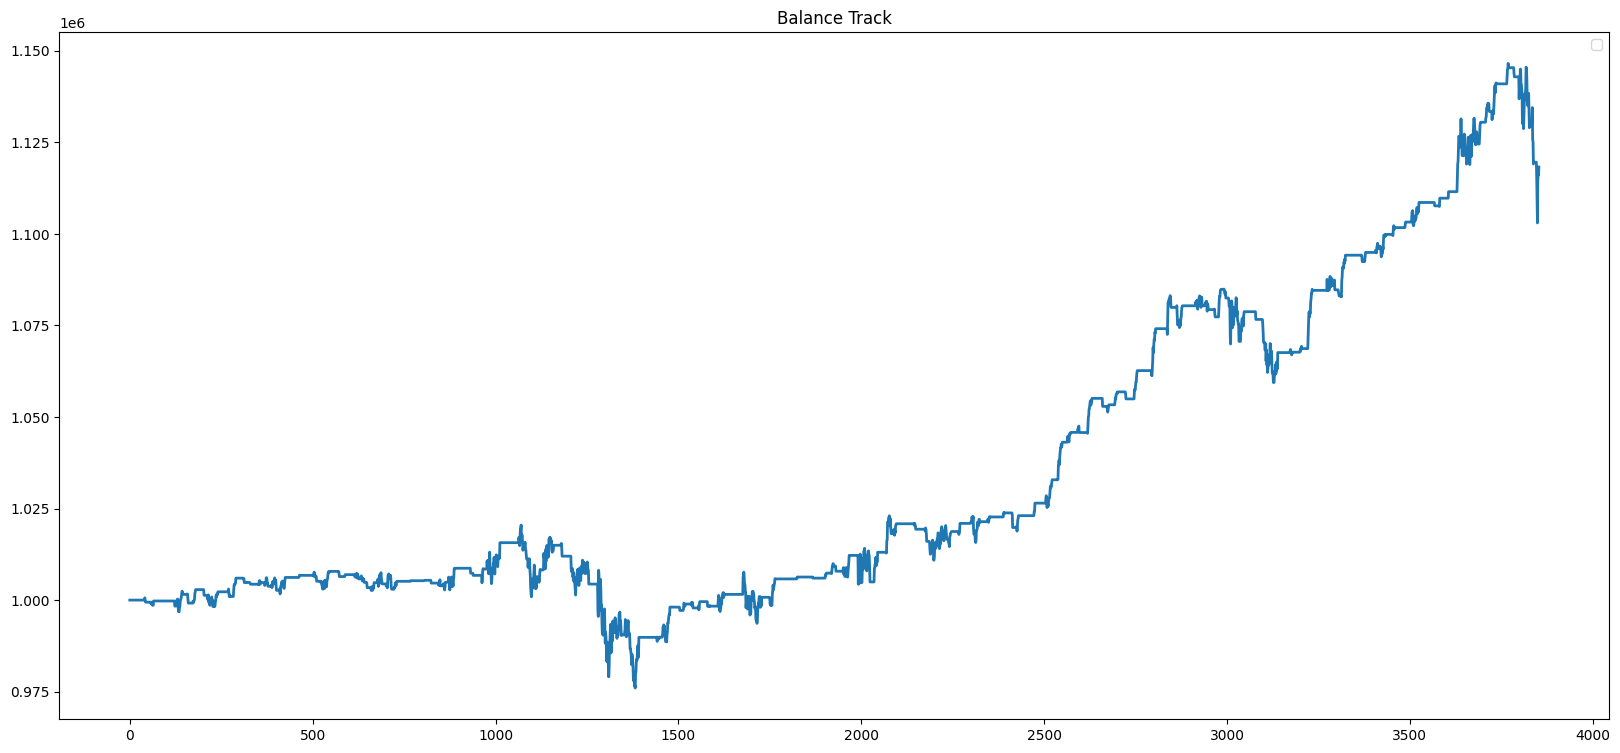

In [138]:
# Balance PLOT
balance_track = [1000000]
balance = 1000000
for i in tsi_investment_ret:
    balance += i
    balance_track.append(balance)
plt.figure(figsize=(20, 20))  # Set the figure size to be larger

ax1 = plt.subplot2grid((11,1), (0,0), rowspan=5, colspan=1)

ax1.plot(balance_track, linewidth = 2)

ax1.legend()
ax1.set_title('Balance Track')

plt.show()

In [139]:
# SPY ETF COMPARISON
spy = list_aggs(
        get_client(), "SPY", 1, "day", "2023-01-01", "2024-02-03", limit=50000
    )

# Assuming df is your DataFrame with columns 'close', 'datetime', and 'SMA'
spy.set_index('datetime', inplace=True)

In [140]:

def get_benchmark(investment_value,Data):
    spy = Data['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark(100000,spy)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('TSI Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $100k : 22933.06
Benchmark Profit percentage : 22%
TSI Strategy profit is 96% higher than the Benchmark Profit


/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/1476212828.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  number_of_stocks = floor(investment_value/spy[-1])


# Improvement

#### 1.position sizing system design: In this article, our algorithm buys and sells the same amount of stocks for all trades but that would not be an optimal decision to make while trading in the real world since it’s arbitrary, and here is where the concept of position sizing comes into play. For those who don’t have an idea about this concept, position sizing is the process of allocating a share of our portfolio to a specific stock we would like to trade. What we could do is, we can deploy a position sizing system that assesses the risk involved in each trade and allocate the number of shares accordingly. This will not only boost the performance substantially but also prevents us from facing unexpected losses. So, I highly recommend you follow up with this concept and try implementing it into a trading strategy.

#### 2.RSI Enhancement

In [141]:
import numpy as np
import pandas as pd
from math import floor
from termcolor import colored as cl
from Strategy_metrics import StrategyStatistics


spy = list_aggs(get_client(), "SPY", 1, "day", "2023-01-01", "2024-02-03", limit=50000)

def get_returns(data):
    spy_close = data['close']
    returns = np.diff(spy_close) / spy_close[:-1]
    return returns

def get_risk_free_rate():

    return 0.0424  

strategy_returns = get_returns(spy)
risk_free_rate = get_risk_free_rate()


strategy_stats = StrategyStatistics(
    trades=len(strategy_returns),
    wins=sum(strategy_returns > 0),
    losses=sum(strategy_returns < 0),
    profits=[profit for profit in strategy_returns if profit > 0],
    losses_amount=[-loss for loss in strategy_returns if loss < 0],
    win_amounts=[profit for profit in strategy_returns if profit > 0],
    fees=[0] * len(strategy_returns)  )

total_trades = strategy_stats.total_trades()
average_win = strategy_stats.average_win()
average_loss = strategy_stats.average_loss()
compounding_annual_return = strategy_stats.compounding_annual_return(100000, 150000, 1)
expectancy = strategy_stats.expectancy()
net_profit = strategy_stats.net_profit()
sortino_ratio = strategy_stats.sortino_ratio(strategy_returns, risk_free_rate)
probabilistic_sharpe_ratio = strategy_stats.probabilistic_sharpe_ratio(strategy_returns, risk_free_rate)
loss_rate = strategy_stats.loss_rate()
win_rate = strategy_stats.win_rate()
profit_loss_ratio = strategy_stats.profit_loss_ratio()
alpha = strategy_stats.alpha(strategy_returns, strategy_returns, risk_free_rate)
beta = strategy_stats.beta(strategy_returns, strategy_returns)
annual_standard_deviation = strategy_stats.annual_standard_deviation(strategy_returns)
annual_variance = strategy_stats.annual_variance(strategy_returns)
information_ratio = strategy_stats.information_ratio(strategy_returns, strategy_returns)
tracking_error = strategy_stats.tracking_error(strategy_returns, strategy_returns)
treynor_ratio = strategy_stats.treynor_ratio(strategy_returns, strategy_returns, risk_free_rate)
total_fees = strategy_stats.total_fees()
estimated_strategy_capacity = strategy_stats.estimated_strategy_capacity(1000000, total_trades)
lowest_capacity_asset = strategy_stats.lowest_capacity_asset([100000, 200000, 300000])
portfolio_turnover = strategy_stats.portfolio_turnover(total_trades, 1000000)

print("Ticker:SPY")
print(cl('Total Trades: {}'.format(total_trades), attrs=['bold']))
print(cl('Average Win: {}'.format(average_win), attrs=['bold']))
print(cl('Average Loss: {}'.format(average_loss), attrs=['bold']))
print(cl('Compounding Annual Return: {}'.format(compounding_annual_return), attrs=['bold']))
print(cl('Expectancy: {}'.format(expectancy), attrs=['bold']))
print(cl('Net Profit: {}'.format(net_profit), attrs=['bold']))
print(cl('Sortino Ratio: {}'.format(sortino_ratio), attrs=['bold']))
print(cl('Probabilistic Sharpe Ratio: {}'.format(probabilistic_sharpe_ratio), attrs=['bold']))
print(cl('Loss Rate: {}'.format(loss_rate), attrs=['bold']))
print(cl('Win Rate: {}'.format(win_rate), attrs=['bold']))
print(cl('Profit Loss Ratio: {}'.format(profit_loss_ratio), attrs=['bold']))
print(cl('Alpha: {}'.format(alpha), attrs=['bold']))
print(cl('Beta: {}'.format(beta), attrs=['bold']))
print(cl('Annual Standard Deviation: {}'.format(annual_standard_deviation), attrs=['bold']))
print(cl('Annual Variance: {}'.format(annual_variance), attrs=['bold']))
print(cl('Information Ratio: {}'.format(information_ratio), attrs=['bold']))
print(cl('Tracking Error: {}'.format(tracking_error), attrs=['bold']))
print(cl('Treynor Ratio: {}'.format(treynor_ratio), attrs=['bold']))
print(cl('Total Fees: {}'.format(total_fees), attrs=['bold']))
print(cl('Estimated Strategy Capacity: {}'.format(estimated_strategy_capacity), attrs=['bold']))
print(cl('Lowest Capacity Asset: {}'.format(lowest_capacity_asset), attrs=['bold']))
print(cl('Portfolio Turnover: {}'.format(portfolio_turnover), attrs=['bold']))


Ticker:SPY
Total Trades: 272
Average Win: 0.0066490122219138885
Average Loss: 0.006331075688243974
Compounding Annual Return: 0.5
Expectancy: 0.0009934997747795438
Net Profit: 1.017298869952825
Sortino Ratio: 2.600372787917718
Probabilistic Sharpe Ratio: -5.035640463587234
Loss Rate: 0.4338235294117647
Win Rate: 0.5625
Profit Loss Ratio: 1.36172386629581
Alpha: 0.0
Beta: 1.0
Annual Standard Deviation: 0.13053112474924272
Annual Variance: 0.017038374528302366
Information Ratio: 0
Tracking Error: 0.0
Treynor Ratio: -0.04140650022522046
Total Fees: 0
Estimated Strategy Capacity: 3676.470588235294
Lowest Capacity Asset: 100000
Portfolio Turnover: 0.000272


In [142]:
import pandas as pd 
import numpy as np 
from math import floor 
from termcolor import colored as cl 


pd.set_option('display.width', None)


amzn_ret = pd.DataFrame(np.diff(df['close'])).rename(columns={0: 'returns'})
tsi_strategy_ret = []

for i in range(len(amzn_ret)):
    returns = amzn_ret['returns'][i] * strategy['tsi_position'][i]
    tsi_strategy_ret.append(returns)
    
tsi_strategy_ret_df = pd.DataFrame(tsi_strategy_ret).rename(columns={0: 'tsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value / df['close'][0])
tsi_investment_ret = []

for i in range(len(tsi_strategy_ret_df['tsi_returns'])):
    returns = number_of_stocks * tsi_strategy_ret_df['tsi_returns'][i]
    tsi_investment_ret.append(returns)

tsi_investment_ret_df = pd.DataFrame(tsi_investment_ret).rename(columns={0: 'investment_returns'})
total_investment_ret = round(sum(tsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)

amzn_returns = np.diff(df['close']) / df['close'][:-1]
amzn_returns = np.insert(amzn_returns, 0, 0)

strategy_stats = StrategyStatistics(
    trades=len(tsi_strategy_ret),
    wins=sum([1 for ret in tsi_strategy_ret if ret > 0]),
    losses=sum([1 for ret in tsi_strategy_ret if ret < 0]),
    profits=[ret for ret in tsi_strategy_ret if ret > 0],
    losses_amount=[-ret for ret in tsi_strategy_ret if ret < 0],
    win_amounts=[ret for ret in tsi_strategy_ret if ret > 0],
    fees=[0] * len(tsi_strategy_ret)  
)

risk_free_rate = 0.0424 
tsi_strategy_returns = tsi_strategy_ret_df['tsi_returns'].values
sharpe_ratio = strategy_stats.sharpe_ratio(tsi_strategy_returns, risk_free_rate)

print(cl('Profit gained from the TSI strategy by investing $100k in {}: {}'.format("SPY", total_investment_ret), attrs=['bold']))
print(cl('Profit percentage of the TSI strategy for {}: {}%'.format("SPY", profit_percentage), attrs=['bold']))
print(cl('Sharpe Ratio: {}'.format(sharpe_ratio), attrs=['bold']))
print(cl('Total Trades: {}'.format(strategy_stats.total_trades()), attrs=['bold']))
print(cl('Wins: {}'.format(strategy_stats.wins), attrs=['bold']))
print(cl('Losses: {}'.format(strategy_stats.losses), attrs=['bold']))
print(cl('Average Win: {}'.format(strategy_stats.average_win()), attrs=['bold']))
print(cl('Average Loss: {}'.format(strategy_stats.average_loss()), attrs=['bold']))
print(cl('Expectancy: {}'.format(strategy_stats.expectancy()), attrs=['bold']))
print(cl('Net Profit: {}'.format(strategy_stats.net_profit()), attrs=['bold']))
print(cl('Loss Rate: {}'.format(strategy_stats.loss_rate()), attrs=['bold']))
print(cl('Win Rate: {}'.format(strategy_stats.win_rate()), attrs=['bold']))
print(cl('Profit Loss Ratio: {}'.format(strategy_stats.profit_loss_ratio()), attrs=['bold']))


Profit gained from the TSI strategy by investing $100k in SPY: 118270.12
Profit percentage of the TSI strategy for SPY: 118%
Sharpe Ratio: 0.4314784614552479
Total Trades: 3853
Wins: 784
Losses: 660
Average Win: 1.255451275510202
Average Loss: 1.308469696969696
Expectancy: 0.03132203477809473
Net Profit: 984.2737999999985
Loss Rate: 0.17129509473137813
Win Rate: 0.2034778094990916
Profit Loss Ratio: 1.1397466390300943


/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/2202956895.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = amzn_ret['returns'][i] * strategy['tsi_position'][i]
/var/folders/pq/lmfrpjwx21x5_6mbm8qctwv40000gn/T/ipykernel_11440/2202956895.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  number_of_stocks = floor(investment_value / df['close'][0])
